In [1]:
%config IPCompleter.greedy=True

## Libraries

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from pprint import pprint

## Helper Functions

In [3]:
from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

In [4]:
def show_scores(result):
    for k, v in result.items():
        if k == 'fit_time' or k == 'score_time':
            continue
        else:
            print(f"{k:20} \t{v.mean():.4f}\t{v.std():>.8f} ")
    print()

In [5]:
def create_classifier(clf, parameters, show_matrix=True):
    skfold = model_selection.StratifiedKFold(n_splits=k_splits, shuffle=True, random_state=seed)

    for scorer in test_scoring:
        GS = GridSearchCV(clf, parameters, cv=skfold, scoring=scorer, n_jobs=-1,)
        GS.fit(X_train, y_train)
        print(f"{scorer} {GS.best_params_}\n {GS.best_score_}\n")
        if scorer == main_scorer:
            best_clf = GS.best_estimator_

    new_models.append(best_clf)

    cv_results = model_selection.cross_validate(best_clf, X_test, y_test, cv=skfold, scoring=scoring, n_jobs=-1)
    new_results.append(cv_results)

    show_scores(cv_results)
    if show_matrix:
        plot_matrix(best_clf, X_test, y_test)
    return best_clf

In [6]:
def plot_matrix(clf, X_test, y_test, show_print=False):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12,6))

    titles_options = [("Confusion matrix, without normalization", None, ax1),
                    ("Normalized confusion matrix", 'true', ax2)]
    for title, normalize, ax in titles_options:
        disp = plot_confusion_matrix(clf, X_test, y_test,
                                    cmap=plt.cm.Blues,
                                    normalize=normalize,
                                    ax=ax)
        disp.ax_.set_title(title)
        if show_print:
            print(title)
            print(disp.confusion_matrix)
    plt.draw()

# Data

## Data Set Preparations

In [7]:
df = pd.read_csv("outputs\songs.csv")
df.rename(columns={'Unnamed: 0': 'station_index'}, inplace=True)

df_X = df.iloc[:, 3:16]
df_y = df.liked

X = np.array(df.iloc[:, 3:16])
y = np.array(df.liked)

print(list(df_X.columns))
print(X.shape)

['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']
(2769, 13)


In [8]:
df.head()

,station_index,name,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,liked
0,0,I Don't Wanna Love You Anymore,LANY,0.702,0.623,0,-8.360,1,0.0417,0.3220,0.000000,0.0858,0.503,104.974,201198,4,1
1,1937,Beautiful Disaster,Jon McLaughlin,0.432,0.664,7,-4.662,1,0.0302,0.2150,0.000000,0.1500,0.294,156.216,251640,4,1
2,1925,Gone Too Soon,Simple Plan,0.204,0.811,2,-4.326,1,0.0313,0.0119,0.000000,0.0908,0.296,87.903,195547,4,1
3,1930,Your Guardian Angel,The Red Jumpsuit Apparatus,0.290,0.480,5,-6.583,1,0.0296,0.1160,0.000003,0.6260,0.382,112.620,229235,4,1
4,1931,Fall For Anything,The Script,0.558,0.842,10,-4.381,0,0.0340,0.1170,0.000000,0.0672,0.491,123.048,272773,4,1


In [9]:
df_X.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.702,0.623,0,-8.360,1,0.0417,0.3220,0.000000,0.0858,0.503,104.974,201198,4
1,0.432,0.664,7,-4.662,1,0.0302,0.2150,0.000000,0.1500,0.294,156.216,251640,4
2,0.204,0.811,2,-4.326,1,0.0313,0.0119,0.000000,0.0908,0.296,87.903,195547,4
3,0.290,0.480,5,-6.583,1,0.0296,0.1160,0.000003,0.6260,0.382,112.620,229235,4
4,0.558,0.842,10,-4.381,0,0.0340,0.1170,0.000000,0.0672,0.491,123.048,272773,4


In [10]:
df_X.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000
mean,0.602809,0.690871,5.237631,-6.076351,0.682196,0.078640,0.196182,0.058485,0.193433,0.510321,122.251697,219589.224269,3.966053
std,0.139289,0.197969,3.591076,3.194620,0.465707,0.077134,0.263128,0.203739,0.157193,0.227006,29.179527,45944.105725,0.263925
min,0.000000,0.004840,0.000000,-35.068000,0.000000,0.000000,0.000004,0.000000,0.000000,0.000000,0.000000,4366.000000,0.000000
25%,0.514000,0.571000,2.000000,-7.051000,0.000000,0.036300,0.013000,0.000000,0.095000,0.335000,98.072000,195547.000000,4.000000
50%,0.612000,0.731000,5.000000,-5.382000,1.000000,0.050800,0.073100,0.000000,0.130000,0.508000,120.971000,214648.000000,4.000000
75%,0.700000,0.845000,8.000000,-4.154000,1.000000,0.083500,0.264000,0.000046,0.253000,0.680000,140.060000,238027.000000,4.000000
max,0.967000,0.993000,11.000000,-0.005000,1.000000,0.967000,0.995000,0.979000,0.976000,0.975000,214.118000,850467.000000,5.000000


## Data Explorations

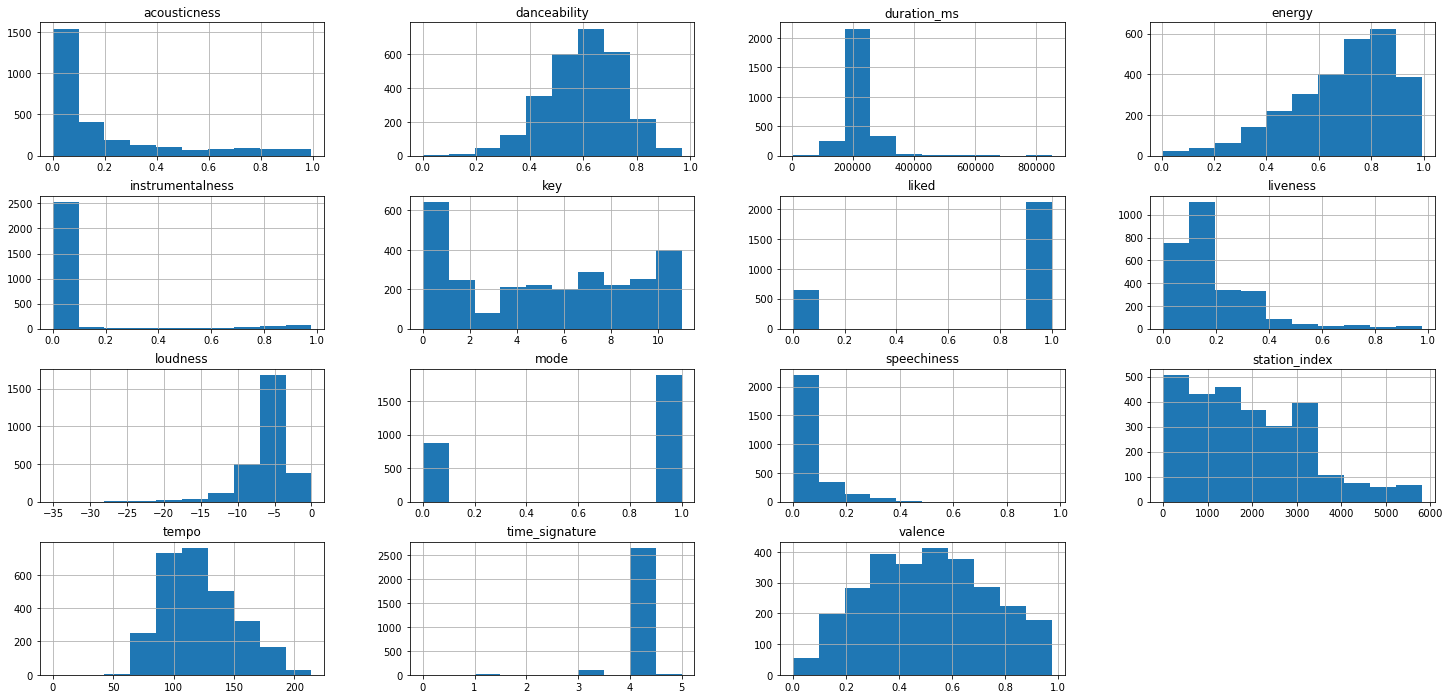

In [11]:
fig = plt.figure(figsize = (25,12))
ax = fig.gca()

df.hist(ax = ax)
plt.draw()

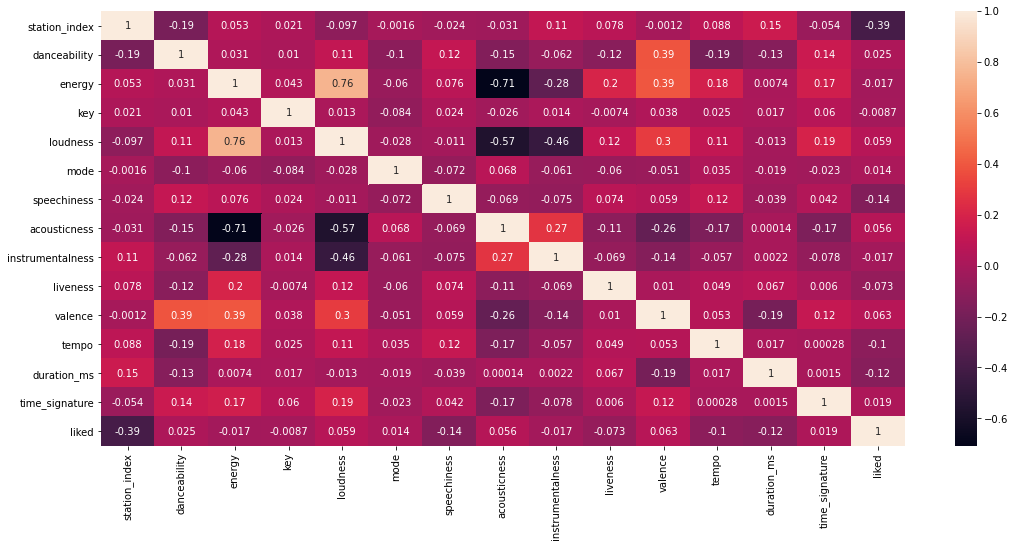

In [12]:
correlations = df.corr()
fig = plt.figure(figsize = (18,8))
sns.heatmap(correlations, xticklabels=correlations.columns, yticklabels=correlations.columns, annot=True)
plt.draw()

Trues: 0.7652582159624414 Falses: 0.2347417840375587


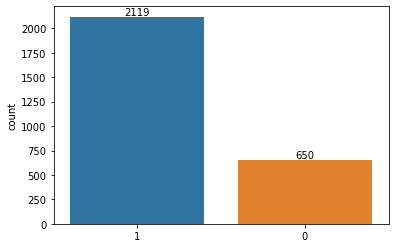

In [13]:
ax = sns.countplot(y, label="Sum", order=[1, 0])
values = df.liked.value_counts().values
value_total = values[0] + values[1]

for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 20, values[i], ha="center")
plt.draw()

print(f"Trues: {values[0]/value_total} Falses: {values[1]/value_total}")

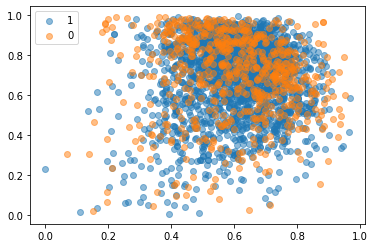

In [35]:
counter = Counter(y)
for label, _ in counter.items():
	row_ix = np.where(y == label)[0]
	plt.scatter(X[row_ix, 0], X[row_ix, 1], alpha=0.5, label=str(label))
plt.legend()
plt.draw()

# Feature Engineering

## Imports

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

import sklearn.metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score

## Feature Selection

In [16]:
standard_scaler = StandardScaler()
robust_scaler = RobustScaler()
min_max_scalar = MinMaxScaler()

standard_X = standard_scaler.fit_transform(df_X)
robust_X = robust_scaler.fit_transform(df_X)
min_max_X = min_max_scalar.fit_transform(df_X)

In [17]:
sel = VarianceThreshold(threshold=.1)
sel.fit(df_X)
sel_X = sel.transform(df_X)

cols_indices = [(col, index) for col, index in zip(df_X.columns, sel.get_support()) if index == True]
pprint(cols_indices)

[('key', True),
 ('loudness', True),
 ('mode', True),
 ('tempo', True),
 ('duration_ms', True)]


In [18]:
df_columns = pd.DataFrame(df_X.columns)

In [19]:
dependency = [f_classif, mutual_info_classif]
scalers = [df_X, standard_X, robust_X, min_max_X]

feature_scores = []
for scale in scalers:
    for test in dependency:
        best_features = SelectKBest(score_func=test, k='all')

        fit = best_features.fit(scale, df_y)

        feature_results = pd.DataFrame(fit.scores_)
        feature_results = pd.concat([df_columns, feature_results], axis=1)
        feature_results.columns = ['Features', 'Score']
        feature_results.sort_values(['Score'], inplace=True, ascending=False)
        feature_scores.append(feature_results)

In [20]:
scale_name  = ['df_X', 'standard_X', 'robust_X', 'min_max_X']
dependency_name = [f"{name}: [{scale}]" for scale in scale_name for name in ["F", "MI"] ]

display_side_by_side(feature_scores, dependency_name)

,Features,Score
5,speechiness,56.858382
11,duration_ms,43.178999
10,tempo,30.440568
8,liveness,14.882412
9,valence,11.134631
3,loudness,9.825199
6,acousticness,8.722136
0,danceability,1.750758
12,time_signature,1.016377
1,energy,0.809717


# Modeling

## Imports

In [21]:
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 

from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC


## Configuration

In [22]:
seed = 10
k_splits = 13
scoring = ['accuracy', 'balanced_accuracy', 'precision', 'recall' , 'f1', 'average_precision', 'roc_auc']
test_scoring = ['balanced_accuracy', 'f1', 'average_precision', 'roc_auc']
main_scorer = 'balanced_accuracy'

## Base Models

In [23]:
base_models = []
base_models.append(DecisionTreeClassifier())
base_models.append(GaussianNB())
base_models.append(KNeighborsClassifier())
base_models.append(LinearDiscriminantAnalysis())
base_models.append(LogisticRegression())
base_models.append(QuadraticDiscriminantAnalysis())
base_models.append(SVC())

In [24]:
X_base = X
y_base = y

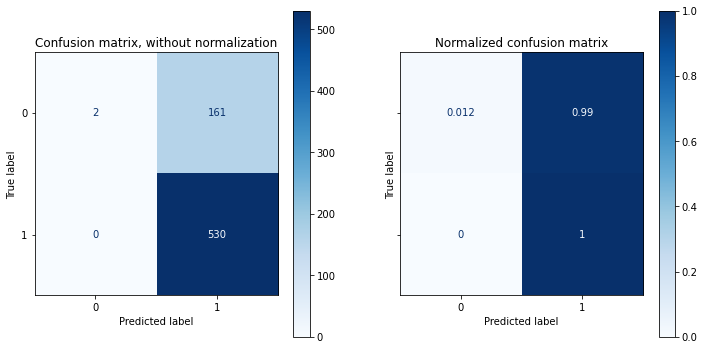

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_base, y, random_state=seed, shuffle=True, stratify=y)

clf = SVC()
clf.fit(X_train, y_train)

plot_matrix(clf, X_test, y_test)

In [26]:
base_results = []

for model in base_models:
    skfold = model_selection.StratifiedKFold(n_splits=k_splits, shuffle=True, random_state=seed)
    cv_results = model_selection.cross_validate(model, X_base, y_base, cv=skfold, scoring=scoring)
    base_results.append(cv_results)

In [27]:

for model, result in zip(base_models, base_results):
    print(f"{model}")
    print(f"Parameter\t\t Mean\t Std")
    show_scores(result)

DecisionTreeClassifier()
Parameter		 Mean	 Std
test_accuracy        	0.6410	0.02304522 
test_balanced_accuracy 	0.5170	0.03140128 
test_precision       	0.7736	0.01544978 
test_recall          	0.7508	0.02327292 
test_f1              	0.7619	0.01667069 
test_average_precision 	0.7719	0.01205096 
test_roc_auc         	0.5178	0.03219875 

GaussianNB()
Parameter		 Mean	 Std
test_accuracy        	0.7588	0.01742483 
test_balanced_accuracy 	0.5224	0.02099262 
test_precision       	0.7737	0.00795902 
test_recall          	0.9679	0.01850748 
test_f1              	0.8599	0.01088297 
test_average_precision 	0.8295	0.02272813 
test_roc_auc         	0.6225	0.04800923 

KNeighborsClassifier()
Parameter		 Mean	 Std
test_accuracy        	0.7277	0.02630140 
test_balanced_accuracy 	0.5213	0.03137252 
test_precision       	0.7737	0.01243543 
test_recall          	0.9103	0.02552738 
test_f1              	0.8364	0.01686881 
test_average_precision 	0.7787	0.02268075 
test_roc_auc         	0.5284	0.05272303

## New Models

In [28]:
new_models = []
new_results = []

X_train, X_test, y_train, y_test = train_test_split(min_max_X, y, random_state=seed, shuffle=True, stratify=y)

In [ ]:
counter = Counter(y_train)
for label, _ in counter.items():
	row_ix = np.where(y_train == label)[0]
	plt.scatter(X_train[row_ix, 0], X_train[row_ix, 1], alpha=0.5, label=str(label))
plt.legend()
plt.draw()

In [ ]:
parameters = {
    'max_depth':[None] + [i for i in range(2,10)],
    'class_weight': [None, 'balanced'],
    'min_samples_split': [i for i in range(1, 41)],
    'min_samples_leaf': [i for i in range(1, 21)],
    #'max_features': [None, 'auto', 'log']
    }
clf = create_classifier(DecisionTreeClassifier(), parameters)
plot_matrix(clf, X_test, y_test)

balanced_accuracy {}
 0.5741065940038983

f1 {}
 0.8429855772741466

average_precision {}
 0.8501196854393758

roc_auc {}
 0.6620421058698379

test_accuracy        	0.7186	0.05743234 
test_balanced_accuracy 	0.5741	0.07040710 
test_precision       	0.7973	0.03300691 
test_recall          	0.8470	0.05162412 
test_f1              	0.8211	0.03867460 
test_average_precision 	0.8430	0.03851733 
test_roc_auc         	0.6309	0.07171696 



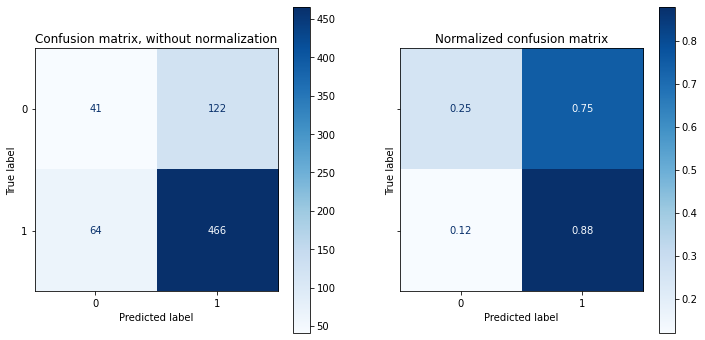

In [29]:
parameters = {}
clf = create_classifier(GaussianNB(), parameters)

In [ ]:
parameters = {
    'n_neighbors': [i for i in range(1, 31, 2)],
    'weights': ['uniform', 'distance'],
    'leaf_size': [i for i in range(1, 61, 3)],
    'p': [1, 2, 5],
    }
clf = create_classifier(KNeighborsClassifier(), parameters)

balanced_accuracy {'solver': 'svd'}
 0.5345029074484661

f1 {'shrinkage': 'auto', 'solver': 'lsqr'}
 0.8670801488934406

average_precision {'solver': 'svd'}
 0.8450237023634544

roc_auc {'solver': 'svd'}
 0.656461714107077

test_accuracy        	0.7750	0.02125021 
test_balanced_accuracy 	0.5405	0.03442663 
test_precision       	0.7802	0.01460948 
test_recall          	0.9830	0.02042940 
test_f1              	0.8698	0.01268118 
test_average_precision 	0.8393	0.05508839 
test_roc_auc         	0.6190	0.09522388 



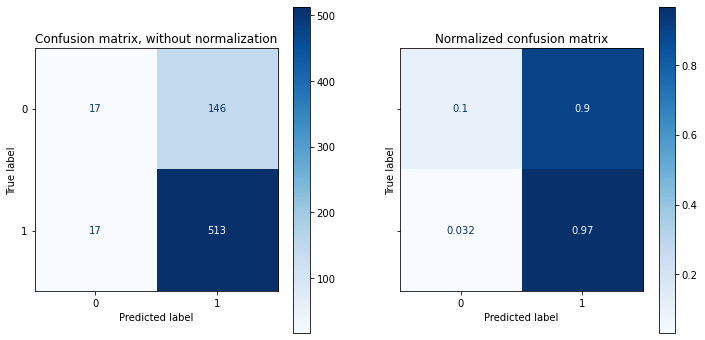

In [30]:
parameters = [
        {
            'solver': ['svd']
        },
        {
            'solver': ['lsqr', 'eigen'],
            'shrinkage': [None, 'auto']
        }
    ]
clf = create_classifier(LinearDiscriminantAnalysis(), parameters)

balanced_accuracy {'C': 100, 'class_weight': 'balanced', 'max_iter': 300, 'penalty': 'l1', 'solver': 'liblinear'}
 0.6214077705533755

f1 {'C': 100, 'class_weight': None, 'max_iter': 300, 'penalty': 'l2', 'solver': 'newton-cg'}
 0.8683279798632392

average_precision {'C': 10, 'class_weight': 'balanced', 'max_iter': 300, 'penalty': 'l1', 'solver': 'liblinear'}
 0.8480194602111646

roc_auc {'C': 50, 'class_weight': 'balanced', 'max_iter': 300, 'penalty': 'l1', 'solver': 'liblinear'}
 0.658865450427773

test_accuracy        	0.6032	0.07195652 
test_balanced_accuracy 	0.5727	0.08792961 
test_precision       	0.8084	0.05546933 
test_recall          	0.6302	0.06871212 
test_f1              	0.7070	0.05948596 
test_average_precision 	0.8376	0.05413705 
test_roc_auc         	0.6174	0.09336039 



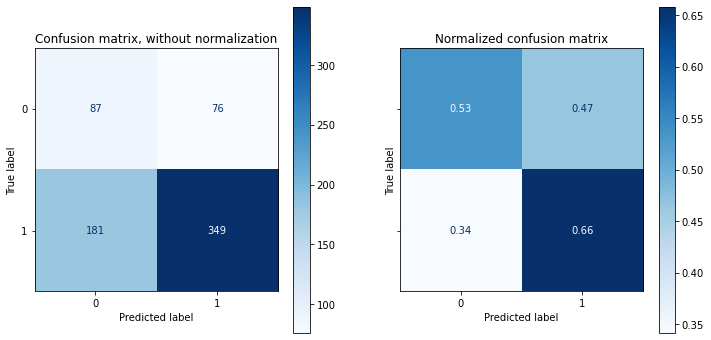

In [31]:
parameters = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10, 50, 100, 200, 500, 1000],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag'],
    'max_iter': [300, 500],
    'class_weight': [None, 'balanced']
    }

clf = create_classifier(LogisticRegression(), parameters)

balanced_accuracy {'reg_param': 0.001}
 0.5791370106223114

f1 {'reg_param': 0.01}
 0.8689107386098414

average_precision {'reg_param': 0.001}
 0.84550820529286

roc_auc {'reg_param': 0.001}
 0.6612200872286311

test_accuracy        	0.7259	0.04759732 
test_balanced_accuracy 	0.5671	0.06795829 
test_precision       	0.7946	0.02956022 
test_recall          	0.8659	0.04800179 
test_f1              	0.8281	0.03203582 
test_average_precision 	0.8339	0.04087534 
test_roc_auc         	0.6144	0.08382369 



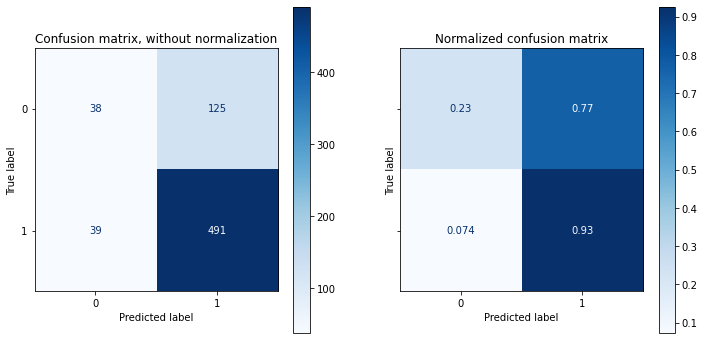

In [32]:
parameters = {
    'reg_param': [None, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    }

clf = create_classifier(QuadraticDiscriminantAnalysis(), parameters)

balanced_accuracy {'C': 50, 'class_weight': None, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': 500}
 0.5678418824686633

f1 {'C': 1, 'class_weight': None, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': 500}
 0.8695916299275678

average_precision {'C': 1, 'class_weight': None, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly', 'max_iter': 500}
 0.8400162593178684

roc_auc {'C': 0.1, 'class_weight': None, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': 500}
 0.6389562823883832

test_accuracy        	0.7201	0.03001952 
test_balanced_accuracy 	0.5241	0.04765024 
test_precision       	0.7751	0.02159357 
test_recall          	0.8944	0.03609414 
test_f1              	0.8300	0.01943369 
test_average_precision 	0.8199	0.05247092 
test_roc_auc         	0.5865	0.10145083 



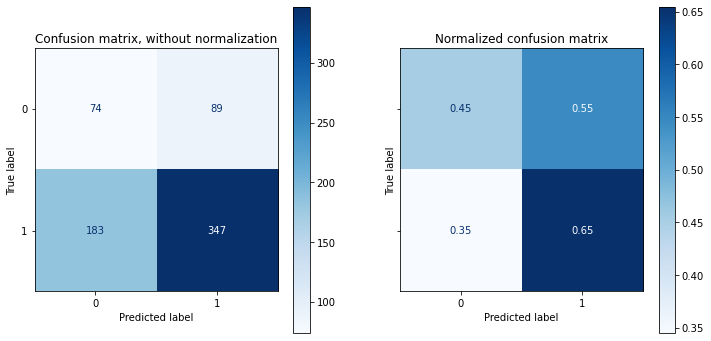

In [33]:
parameters = {
    'C': [0.1, 1, 10, 50, 100, 200, 500, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3],
    'class_weight': [None, 'balanced'],
    'max_iter': [500]
    }

clf = create_classifier(SVC(), parameters)

# Model Comparison

In [ ]:
for base_model, base_result, new_model, new_result in zip(base_models, base_results, new_models, new_results):
    print(f"{str(base_model):26}\t Mean\t\t Std")
    for (base_k, base_v), (new_k, new_v) in zip(base_result.items(), new_result.items()):
        print(f"{base_k:26}\t {(new_v.mean() - base_v.mean()):8.4f}\t {(new_v.std() - base_v.std()):8.4f}")
    print()